# Tensorfaces

This short notebook walks through a basic implementation of **Tensorfaces** [1], using the **Tensorly** [2] library for Python.

Included is the following:

1. [Writing the SVD using the mode-n product](#The-SVD-via-the-mode-n-product)
2. [Forming the image ensemble as a 5th-order tensor](#form-tensor-from-image-dataset)
3. [Computing the mode matrices and core tensor](#computing-the-mode-matrices-$\mathbf{U}_n$-and-core-tensor-$\mathcal{Z}$)
4. [Eigenfaces as a specific instance of Tensorfaces](#subsuming-eigenfaces)
5. [Visualizing the 'eigenmodes'](#eigenmodes)

### download pre-aligned images
- please download pre-aligned versions of the [weizmann face dataset](http://www.wisdom.weizmann.ac.il/~vision/FaceBase/) for the demo from the following public link [https://drive.google.com/file/d/1Kq9EQ9SlskmZ5j2EbQPs6Re4STafgHfg/view](https://drive.google.com/file/d/1Kq9EQ9SlskmZ5j2EbQPs6Re4STafgHfg/view)
- once downloaded, unzip to a folder named `./data-aligned/` in the project's root directory

---

[1]: M. A. O. Vasilescu and D. Terzopoulos, ‘Multilinear Analysis of Image Ensembles: TensorFaces’, in Computer Vision — ECCV 2002, vol. 2350, A. Heyden, G. Sparr, M. Nielsen, and P. Johansen, Eds. Berlin, Heidelberg: Springer Berlin Heidelberg, 2002, pp. 447–460.

[2]: Jean Kossaifi, Yannis Panagakis, Anima Anandkumar and Maja Pantic, TensorLy: Tensor Learning in Python, https://arxiv.org/abs/1610.09555.

In [1]:
from os import listdir
from PIL import Image
from matplotlib import pyplot as plt
from skimage import data
from scipy.linalg import eigh, svd
from sklearn import preprocessing

import tensorly as tl
import numpy as np
import itertools
flatten = itertools.chain.from_iterable

tl.set_backend('pytorch')

# The SVD via the mode-n product

Let $\mathbf{X}\in\mathbb{R}^{H\times W}$ denote a grayscale image. Via the **Singular Value Decomposition** (SVD), we can always decompose such a matrix into a product of two orthonormal matrices $\mathbf{U},\mathbf{V}$ and a diagonal matrix $\Sigma$ using standard matrix multiplication as

$$\mathbf{X} = \mathbf{U}\Sigma\mathbf{V}^\top.$$

**In numpy**:

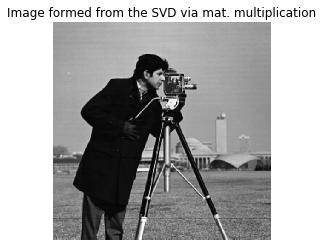

In [2]:
X = data.camera()

# compute the SVD of X and form the original matrix using standard matrix multiplication
U, S, V_top = svd(X)
X_hat_mult = U @ np.diag(S) @ V_top

plt.imshow(X_hat_mult, cmap='gray')
plt.title('Image formed from the SVD via mat. multiplication')
plt.axis(False)
plt.show()

If we now instead view $\mathbf{X}$ as a second-order tensor, we can write the SVD of $\mathbf{X}$ using tensor operations, which will allow us to generalise to higher-order tensors. We first note that the *n-mode product* of an $N$-th order tensor $\mathcal{X}\in\mathbb{R}^{I_1\times I_2\times \cdots \times I_N}$ and matrix $\mathbf{U}\in\mathbb{R}^{J\times I_n}$ is also a tensor [1], of size $I_1\times\cdots\times I_{n-1}\times J \times I_{n+1}\times\cdots I_N$ defined elementwise as

$$\left( \mathcal{X}\times_n\mathbf{U} \right)_{i_1\cdots i_{n-1} j i_{n+1} \cdots i_N} = \sum_{i_n=1}^{I_n}x_{i_1 i_2\cdots i_N}u_{ji_n}.$$

We can also compute the *n-th mode unfolding* of the mode-n product via standard matrix multiplication

$$\mathcal{Y} = \mathcal{X}\times_n \mathbf{U} \Leftrightarrow \mathbf{Y}_{(n)} = \mathbf{UX}_{(n)}.$$

## Writing the SVD in terms of the mode-n product

Now, given the SVD $\mathbf{X}=\mathbf{U}\Sigma\mathbf{V}^\top$, note that we can rewrite this in terms of mode-n products [2] in the following manner

$$\mathbf{X} = \Sigma \times_1 \mathbf{U} \times_2 \mathbf{V}.$$

To see why, let's consider each mode-n product at a time. We compute the first intermediate mode-1 product in terms of the mode-1 unfolding as

$$\left(\Sigma\times_1 \mathbf{U}\right)_{(1)} = \Sigma\times_1 \mathbf{U} = \color{red}{\mathbf{U}\Sigma}.$$

(note that, as we are dealing with second-order tensors, the mode-1 unfolding leaves the matrix untouched, as the column fibers already sit in the columns of the matrix). We then need to compute the mode-2 product of this intermediate tensor $\color{red}{\mathbf{U}\Sigma}$ with the matrix of right-singular vectors

$$
\begin{align} 
    \mathbf{X}_{(2)}
        &= \mathbf{V}\left(\color{red}{\mathbf{U}\Sigma} \right)_{(2)} \\
        &= \mathbf{V}\Sigma\mathbf{U}^\top,
\end{align}
$$

due to the fact that the mode-$2$ unfolding places the row-fibers as the columns of the matrix. Given this mode-2 unfolding of our output $\mathbf{X}_{(2)}$, we finally have to *re-fold* the tensor (i.e. transpose it, in this specific case) to yield our original matrix

$$
\mathbf{X}_{(2)} = \mathbf{V}\Sigma\mathbf{U}^\top \Leftrightarrow \mathbf{X} = \mathbf{U}\Sigma\mathbf{V}^\top.
$$

---

[1]: T. G. Kolda and B. W. Bader, ‘Tensor Decompositions and Applications’, SIAM Rev., vol. 51, no. 3, pp. 455–500, Aug. 2009, doi: 10.1137/07070111X.

[2]: M. A. O. Vasilescu and D. Terzopoulos, ‘Multilinear Analysis of Image Ensembles: TensorFaces’, in Computer Vision — ECCV 2002, vol. 2350, A. Heyden, G. Sparr, M. Nielsen, and P. Johansen, Eds. Berlin, Heidelberg: Springer Berlin Heidelberg, 2002, pp. 447–460.

**To perform this in tensorly**:

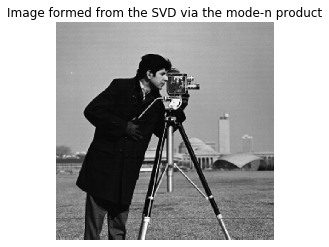

In [3]:
# first we need to form a tensorly tensor from the np.array
X = tl.tensor(data.camera())

# compute the SVD of X
U, S, V_top = tl.partial_svd(X)

# and form the original matrix using the mode-n product:
# (we could also simply use tl.dot here, as we have 2-way tensors)
US = tl.tenalg.mode_dot(tl.tensor(np.diag(S)), U, 0)  # first mode-1 product with the mat of left-singular vectors
X_hat_mode = tl.tenalg.mode_dot(US, V_top.T, 1) # second mode-2 product with the mat of right-singular vectors

plt.imshow(X_hat_mode, cmap='gray')
plt.title('Image formed from the SVD via the mode-n product')
plt.axis(False)
plt.show()

# tensorfaces

Considering now an image dataset $\mathcal{X}\in\mathbb{R}^{28\times 5\times 3\times 2 \times N}$ with 5 modes--people, views, illuminations, expressions, and pixels--we can decompose this full tensor using the "N-mode SVD", by generalising the principle for our toy case above.

First, we need to form the 5th-order tensor $\mathcal{X}$

### form tensor from image dataset

In [4]:
files = [x for x in listdir('./data-aligned/') if '.png' in x and 'mask1' not in x]
attribute_names = ['people', 'views', 'illuminations', 'expressions']
labels = []

img_size = 64
X = np.empty((28, 5, 3, 2, img_size**2))

# store unique labels
attributes = [[] for _ in range(4)]

for i, x in enumerate([x.split('.')[0].split('-') for x in files]):
    for j, a in enumerate(x):
        attributes[j] += [a]

attributes = [list(set(x)) for x in attributes]

# append the images' labels to the labels list
for f in files:
    y_idx = []
    
    # get the index of its label for each mode
    for i, y_att in enumerate(f.split('.')[0].split('-')):
        y_idx += [attributes[i].index(y_att)]
        
    x = np.array(Image.open('./data-aligned/{}'.format(f)).convert('L').resize((img_size, img_size)))
    
    X[y_idx[0], y_idx[1], y_idx[2], y_idx[3]] = np.reshape(x, [-1])
    
    
X = preprocessing.scale(np.reshape(X, [-1, img_size**2]), with_std=False, axis=1)
X = np.reshape(X, [28, 5, 3, 2, -1])
    
X = tl.tensor(X)

print('---')
print('Shape of tensor image ensemble is: {}'.format(X.shape))

---
Shape of tensor image ensemble is: torch.Size([28, 5, 3, 2, 4096])


## visualise training set

- if we iterate over each mode at a time, we vary only a single mode of variation

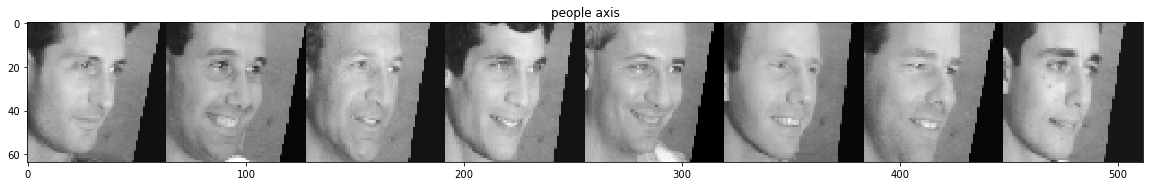

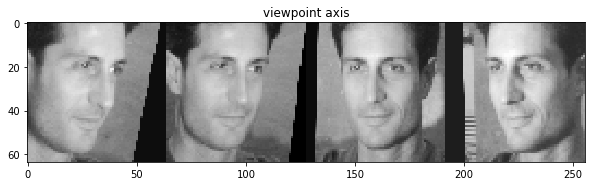

In [5]:
tmp = []
for i in range(8):
    tmp += [tl.reshape(X[i, 0, 0, 0], [img_size, img_size])]
    
tmp = tl.concatenate(tmp, axis=-1)
plt.figure(figsize=(20,20))
plt.title('people axis')
plt.imshow(tmp, cmap='gray')
plt.show()

tmp = []
for i in range(4):
    tmp += [tl.reshape(X[0, i, 0, 0], [img_size, img_size])]
    
tmp = tl.concatenate(tmp, axis=-1)
plt.figure(figsize=(10,10))
plt.title('viewpoint axis')
plt.imshow(tmp, cmap='gray')
plt.show()

## computing the mode matrices $\mathbf{U}_n$ and core tensor $\mathcal{Z}$

We are seeking to represent our image ensemble as a mode-n product of a core tensor $\mathcal{Z}$ and 5 matrices--each one forming an ONB for the relevant space--as follows

$$\mathcal{X} = \mathcal{Z} \times_1 \mathbf{U}_\text{people} \times_2 \mathbf{U}_\text{views} \times_3 \mathbf{U}_\text{illums} \times_4 \mathbf{U}_\text{expres} \times_5 \mathbf{U}_\text{pixels}.$$

The *mode matrix* $\mathbf{U}_n$ for mode $n$ can computed as the orthogonal matrix of left-singular vectors of the mode-$n$ unfolding of our data tensor $\mathbf{X}_{(n)}$. One could then solve for the core tensor via $\mathcal{Z} = \mathcal{X}\times_1 \mathbf{U}^\top_1 \cdots \times_N \mathbf{U}^\top_N.$

In **Tensorly**, we can compute directly a Tucker decomposition of the image ensemble, which gives us the core tensor and list of mode matrices, which instead uses *Higher Order Orthogonal Iteration* [3].

---

[3]: L. De Lathauwer, B. De Moor, and J. Vandewalle, ‘On the Best Rank-1 and Rank-(R1 ,R2 ,. . .,RN) Approximation of Higher-Order Tensors’, SIAM J. Matrix Anal. Appl., vol. 21, no. 4, pp. 1324–1342, Jan. 2000, doi: 10.1137/S0895479898346995.

In [6]:
from tensorly.decomposition import tucker

core, factors = tucker(X)

/home/james/miniconda3/lib/python3.7/site-packages/tensorly/decomposition/_tucker.py:59: Warning: No value given for 'rank'. The decomposition will preserve the original size.
  warnings.warn(message, Warning)


and we can verify that we indeed recover the original images:

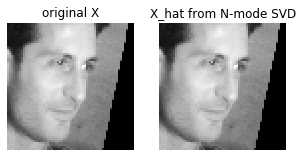

In [7]:
# rebuild X using the mode matrices
X_hat = tl.tucker_to_tensor((core, factors))

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(tl.reshape(X[0, 0, 0, 0], [img_size, img_size]), cmap='gray')
axs[0].set_title('original X')
axs[0].axis(False)

axs[1].imshow(tl.reshape(X_hat[0, 0, 0, 0], [img_size, img_size]), cmap='gray')
axs[1].set_title('X_hat from N-mode SVD')
axs[1].axis(False)
plt.show()

## subsuming eigenfaces

We can view the "eigenfaces" [4] (the leading eigenvectors of the covariance matrix of the vectorized input images) by taking each column of the mode matrix for the pixel mode $\mathbf{U}_\text{pixels}$, and reshaping it using tensorly to a square matrix

---

[4]: M. A. Turk and A. P. Pentland, ‘Face recognition using eigenfaces’, in 1991 IEEE Computer Society Conference on Computer Vision and Pattern Recognition Proceedings, Jun. 1991, pp. 586–591, doi: 10.1109/CVPR.1991.139758.

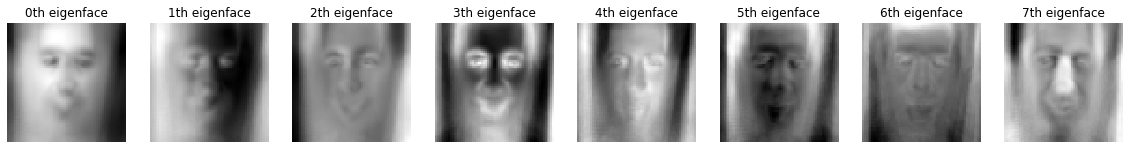

In [8]:
fig, axs = plt.subplots(1, 8, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(tl.reshape(factors[-1][:, i], [img_size, img_size]), cmap='gray')
    ax.set_title('{}th eigenface'.format(i))
    ax.axis(False)

Following the Tensorfaces paper, we can write the original image tensor using a standard linear decomposition, involving the kronecker product of our mode matrices as follows

$$\mathbf{X}_{(\text{pixels})} = \mathbf{U}_\text{pixels}\mathbf{Z}_{(\text{pixels})} = \left( \mathbf{U}_\text{expres} \otimes \mathbf{U}_\text{illums} \otimes \mathbf{U}_\text{views} \otimes \mathbf{U}_\text{people} \right)^\top,$$

and reshape the first column of $\mathbf{D}_{(\text{pixels})}$ to get back the first image in our dataset.

**with tensorly**:

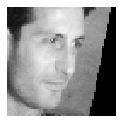

In [9]:
D_pixels = tl.dot(
    factors[-1],
    tl.dot(
        tl.unfold(core, 4),
        tl.tenalg.kronecker(factors[:-1]).T
    )
)

# observe we get back the first image in the training set as the first column of D_pixels
plt.figure(figsize=(2,2))
plt.axis(False)
plt.imshow(tl.reshape(D_pixels[:, 0], [img_size, img_size]), cmap='gray')
plt.show()

# eigenmodes

With such a multilinear analysis, we can inspect the principal axes of variation for *particular modes*, by inspecting the tensor $\mathcal{Z}\times_5\mathbf{U}_\text{pixels}$--named eigenmodes in the Tensorfaces paper. For example, we can iterate over the illumination and people modes to visualise how these modes vary. Note that the top-left image in the figure below is the mean face, corresponding to the principal axis found by PCA from above.

**To do this in Tensorly**:

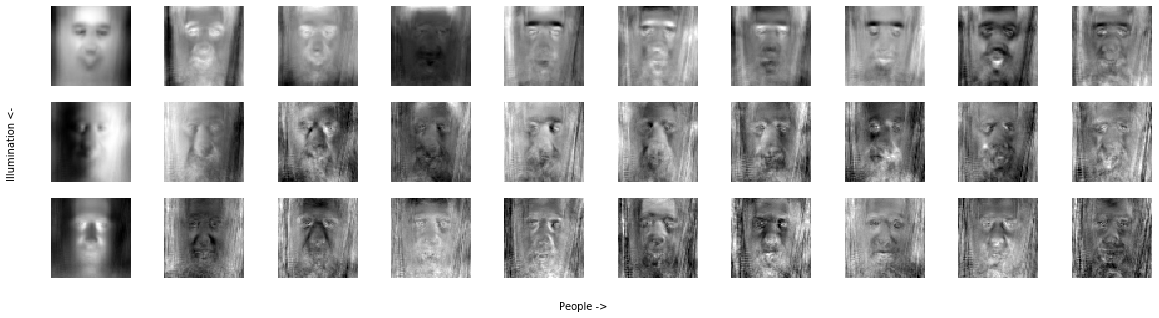

In [10]:
eig_modes = tl.tenalg.mode_dot(core, factors[-1], 4)

fig, axs = plt.subplots(3, 10, figsize=(20, 5))

axs = list(flatten(axs))
count = 0
for i in range(3):
    for j in range(10):
        axs[count].imshow(tl.reshape( eig_modes[j, 0, i, 0, :] , [img_size, img_size]), cmap='gray')
        axs[count].axis(False)

        count += 1
        
fig.text(0.5, 0.04, 'People ->', ha='center')
fig.text(0.10, 0.5, 'Illumination <-', va='center', rotation='vertical')
plt.show()

we can also view e.g. *person-specific* eigenvectors, by computing $\mathcal{Z}\times_1\mathbf{U}_{\text{people}}\times_5\mathbf{U}_{\text{pixels}}$. Computing and plotting this with Tensorly, we once again see the top-left image as the mean face (of the specified identity)

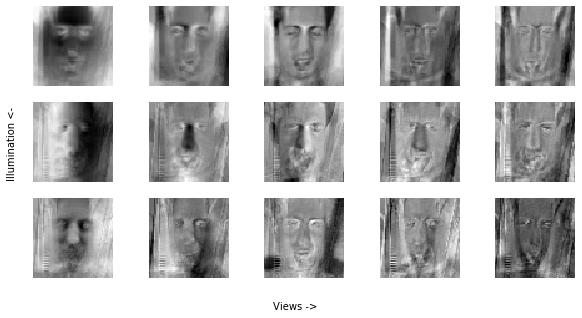

In [11]:
identity = 0

people_bases = tl.tenalg.mode_dot(
    tl.tenalg.mode_dot(core, factors[0], 0), factors[-1], 4)

fig, axs = plt.subplots(3, 5, figsize=(10, 5))

axs = list(flatten(axs))
count = 0
for i in range(3):
    for j in range(5):
        axs[count].imshow(tl.reshape( people_bases[identity, j, i, 0, :] , [img_size, img_size]), cmap='gray')
        axs[count].axis(False)

        count += 1
        
fig.text(0.5, 0.04, 'Views ->', ha='center')
fig.text(0.10, 0.5, 'Illumination <-', va='center', rotation='vertical')
plt.show()